In [1]:
# Dataset testing

import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import sigpy
import pynufft
import skimage
import os
import multiprocessing as mp
from multiprocessing import Pool
from PIL import Image
import tqdm
import glob

from noncart_training.dataset import *
from dnnlib.util import *
from torch_utils import distributed as dist
from torch_utils import misc
from noncart_training.trajectory import *
import generate_conditional

device = torch.device('cuda')

import torchvision

import time

/home/trevor/miniconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def tensor_to_image(images, horv='v'):
    if horv == 'h':
        images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(2, 0, 3, 1).cpu().numpy()
        h,b,w,c = images.shape
        images = images.reshape(h,w*b,c)
    else:
        images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
        h,b,w,c = images.shape
        images = images.reshape(h*b,w,c)
    if images.shape[2] == 3:
        return PIL.Image.fromarray(images, 'RGB')
    else:
        return PIL.Image.fromarray(images[:,:,0], 'L')
    
def image_to_tensor(pil_img):
    tensor_img = torch.tensor(np.array(pil_img))
    if len(tensor_img.shape) == 2:
        tensor_img = ((tensor_img.to(torch.float32) - 128) / 127.5).to(device)
    else:
        assert len(tensor_img.shape) == 3
        tensor_img = ((tensor_img.to(torch.float32) - 128) / 127.5).permute(2, 0, 1).to(device)
    return tensor_img.unsqueeze(0)
    
def image_array(images, columns=4, cmap='gray'):
    fig, axs = plt.subplots(int(len(images)/(columns+.01))+1, columns, figsize=(12,8), frameon=False)
    plt.subplots_adjust(wspace=0, hspace=0)
    if len(images)<=columns:
        for i,img in enumerate(images):
            axs[i].imshow(img, cmap=cmap)
            axs[i].set_axis_off()
    else:
        for i,img in enumerate(images):
            axs[i//columns,i%columns].imshow(img, cmap=cmap)
            axs[i//columns,i%columns].set_axis_off()

In [3]:
def interpolate_values(points,kimage):
    assert kimage.dtype == 'complex64'
    return sigpy.interpolate(kimage, points, kernel='spline', width=2, param=1)
    # mag_image = np.abs(sigpy.ifft(kimage))
    # return sigpy.nufft(mag_image, points)

In [4]:
# # Load dataset.
# seeds = [0,]
# dataset_kwargs = dnnlib.EasyDict(class_name='noncart_training.dataset.NonCartesianDataset', path='../fastMRIprocessing/data_128_multicoil', use_labels=False, xflip=False, fetch_raw=True, undersampling=0.2)
# data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=8, prefetch_factor=2)
# dist.print0('Loading dataset...')
# dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # subclass of training.dataset.Dataset
# dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seeds[0])
# dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, batch_size=1, **data_loader_kwargs))

In [144]:
# Load dataset.
seeds = [0,]
dataset_kwargs = dnnlib.EasyDict(class_name='noncart_training.dataset.NonCartesianDataset', path='../fastMRIprocessing/data_256_multicoil_small', use_labels=False, xflip=False, fetch_raw=True, undersampling=0.05)
data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=8, prefetch_factor=2)
dist.print0('Loading dataset...')
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seeds[0])
dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, batch_size=1, **data_loader_kwargs))

Loading dataset...


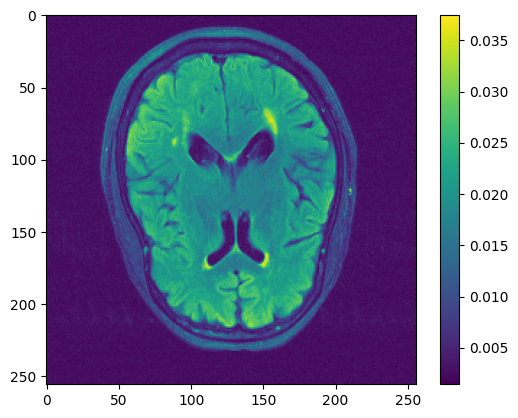

In [205]:
parcel = next(dataset_iterator)
plt.imshow(root_summed_squares(parcel[0])[0].permute(1,2,0))
plt.colorbar()

In [206]:
NufftObj = pynufft.NUFFT()

In [207]:
om = np.array(parcel[3]['points'][0])
om = om/np.amax(om)*np.pi
# om = np.delete(om, np.where((np.hypot(om[:,0],om[:,1]) >= np.pi)), axis=0)

# om = (np.random.rand(100000,2)-0.5)*2*np.pi

# import pkg_resources
# DATA_PATH = pkg_resources.resource_filename('pynufft', './src/data/')
# om = np.load(DATA_PATH+'om2D.npz')['arr_0']

Nd = (256,256)
Kd = (512,512)
Jd = (6,6)

x = parcel[0]
x = np.array(x[:,::2] * (np.cos(x[0,1::2]*np.pi) + np.sin(x[:,1::2]*np.pi) * 1j))
# x = x/torch.amax(x)

batches, channels = x.shape[0], x.shape[1]

# batches = 1
# channels = 2
# x = x[:batches,:channels]

# import scipy
# x = scipy.misc.ascent()[::2, ::2]
# x = x/np.max(x[...])

(-3.4533454535403996,
 3.4556373253578974,
 -3.4443349398126752,
 3.455192292668932)

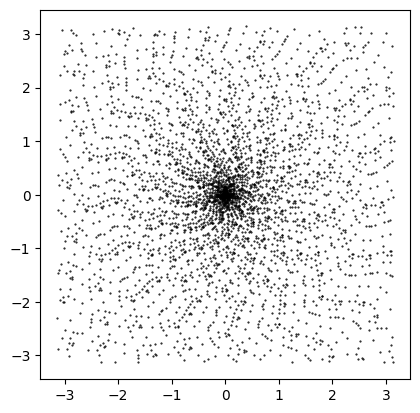

In [208]:
plt.scatter(om[:,0],om[:,1], marker='.', s=1, c='k')
plt.axis('scaled')

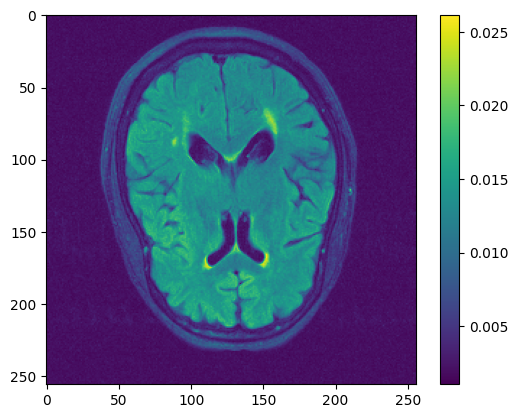

In [209]:
plt.imshow(1-root_summed_squares_complex(x)[0][0])
plt.colorbar()

In [210]:
NufftObj.plan(om, Nd, Kd, Jd)

0

In [211]:
start = time.time()

y = np.zeros((batches,channels,om.shape[0]), dtype=np.complex128)
for b in range(batches):
    for ch in range(channels):
        y[b,ch] = NufftObj.forward(x[b,ch])

end = time.time()
print(end - start)

0.14561843872070312


In [212]:
def root_summed_squares_complex(array):
    assert len(array.shape)==4, f'shape of the tensor to reconstruct should be (batch, channels/magphase(interspersed), H, W), got {array.shape}'
    magnitude = np.abs(array)
    phase = np.angle(array)
    channels = np.count_nonzero(np.count_nonzero(np.sum(magnitude+1,axis=2), axis=2))
    magnitude_combined = np.power(np.sum(np.power((magnitude+1)/2,2),axis=1)/channels,0.5)
    phase_combined = np.power(np.sum(np.power(phase,2),axis=1)/channels,0.5)
    return magnitude_combined, phase_combined

0.11818599700927734


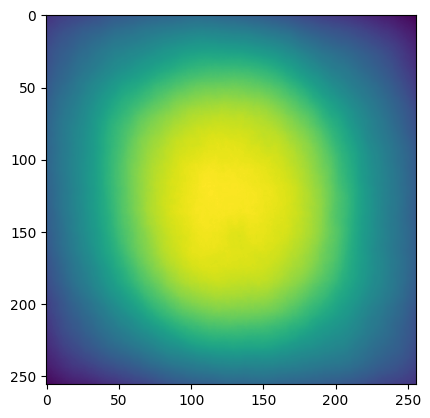

In [213]:
# ADJOINT NUFFT

start = time.time()

x2 = np.zeros((batches,channels,x.shape[-2],x.shape[-1]), dtype=np.complex128)
for b in range(batches):
    for ch in range(channels):
        x2[b,ch] = NufftObj.adjoint(y[b,ch])

end = time.time()
print(end - start)

plt.imshow(root_summed_squares_complex(x2)[0][0])

9.017480850219727


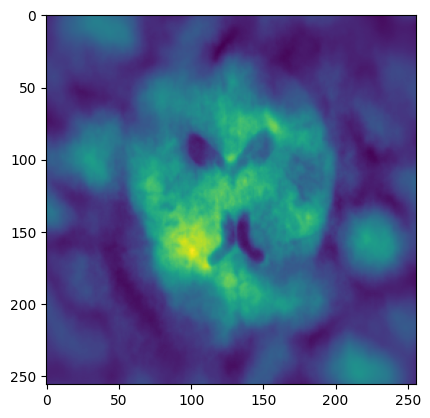

In [214]:
# INVERSE NUFFT W/ CONJUGATE GRADIENTS

start = time.time()

y = np.array(parcel[3]['values'][:,::2] + parcel[3]['values'][:,1::2]*1j)

x3 = np.zeros((batches,channels,x.shape[-2],x.shape[-1]), dtype=np.complex128)

for b in range(batches):
    curr_channels = np.count_nonzero(np.count_nonzero(y, axis=2))
    for ch in range(curr_channels):
        x3[b,ch] = NufftObj.solve(y[b,ch], solver='cg',maxiter=100)

end = time.time()
print(end - start)

plt.imshow(root_summed_squares_complex(x3)[0][0])

In [215]:
y[0,0,3000]

(5.6771382e-06-1.03067855e-07j)

In [216]:
NufftObj.forward(x3)[3000]

(4.930956954075269e-06-4.7802889653808025e-08j)

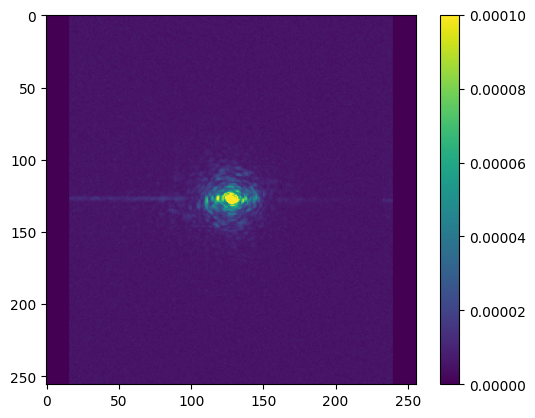

In [419]:
k_complex = parcel[3]['kspace_raw'][0,:,0]+parcel[3]['kspace_raw'][0,:,1]*1j
plt.imshow(torch.mean(torch.abs(k_complex), dim=(0)), vmin=0, vmax=0.0001)
plt.colorbar()

# nufft

    image --nufft--> kspace --nufft_adjoint--> image


    image --nufft--> kspace_pred   --nufft_adjoint-->   image

                         -
                        
                     known kspace                         +

                          ||
                          
                     delta kspace  --nufft_adjoint--> delta image

                                                          ||
                                                        
                                                       image next 



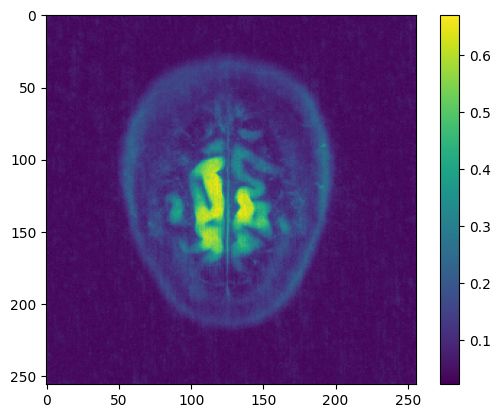

In [15]:
plt.imshow(root_summed_squares(parcel[1])[0].permute(1,2,0))
plt.colorbar()

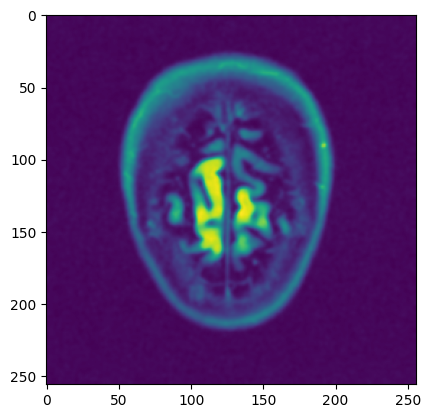

In [421]:
# Generate a fake image to use as a x_t image
blur = torchvision.transforms.GaussianBlur(25)
fake_image = blur(parcel[0])
plt.imshow(root_summed_squares(fake_image)[0].permute(1,2,0))

In [422]:
def interp_nufft(image, points):
    # Array should be in form batch, (magnitude/phase interspersed), width, height
    image = np.array(image.cpu(), dtype=np.float32)
    image_complex = image[:,::2] * (np.cos(image[0,1::2]*np.pi) + np.sin(image[:,1::2]*np.pi) * 1j)

    # plt.imshow(1-np.abs(np.mean(image_complex, axis=(0,1))), vmin=0, vmax=1)

    kspace_complex = sigpy.fft(image_complex)

    # plt.imshow(np.abs(np.mean(kspace_complex, axis=(0,1))), vmin=0, vmax=1)
    # plt.imshow(1-np.abs(np.mean(sigpy.ifft(kspace_complex), axis=(0,1))), vmin=0, vmax=1)

    points = np.array(points, dtype=np.float32)
    values_complex = interpolate_values(points, kspace_complex)
    values_complex = values_complex[:,:,0,:]
    return values_complex

In [423]:
new_values = interp_nufft(fake_image, parcel[3]['points'])[0]
new_values.shape

(24, 72688)

In [424]:
image = np.array(fake_image.cpu(), dtype=np.float32)
image_complex = fake_image[:,::2] * (np.cos(fake_image[0,1::2]*np.pi) + np.sin(fake_image[:,1::2]*np.pi) * 1j)
image_remade = torch.zeros_like(fake_image)
image_remade[:,::2] = torch.abs(image_complex)
image_remade[:,1::2] = torch.angle(image_complex)

In [425]:
image_remade.shape

torch.Size([1, 48, 256, 256])

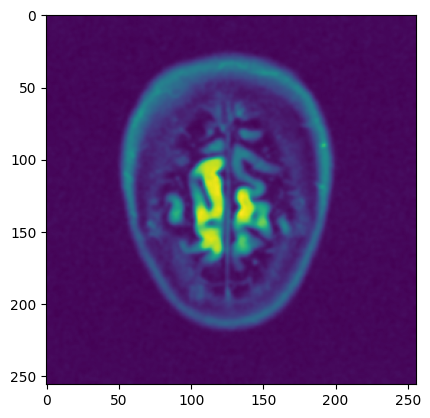

In [426]:
# plt.imshow(1-np.abs(np.average(image_complex, axis=(0,1))), vmin=0, vmax=1)
plt.imshow(root_summed_squares(1-image_remade)[0].permute(1,2,0))

In [427]:
def NUFFT_adjoint_multicoil(points,values,matshape,alpha):
    values_c = fast_density_correction(points,values,alpha)
    coils = values_c.shape[0]
    points = np.tile(points,(coils,1,1))
    image_complex = np.zeros((coils, matshape[0], matshape[1]), dtype=np.complex64)
    for i in range(coils):
        image_complex[i] = sigpy.nufft_adjoint(values_c[i], points[i], oshape=matshape, oversamp=1, width=4).astype(np.complex64)
    return image_complex

(24, 72688)


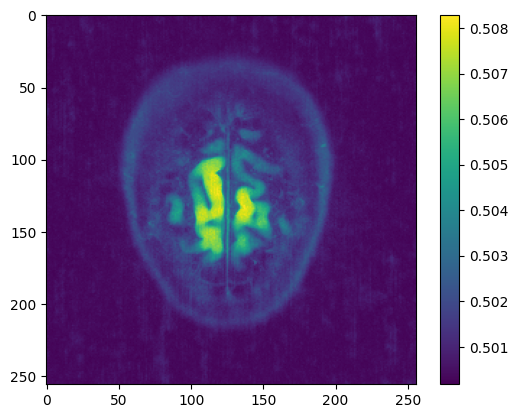

In [428]:
# For starting with the values sampled straight from the dataloader and doing the reconstruction using the adjoint nufft
values_complex = np.array(parcel[3]['values'][0,::2] + parcel[3]['values'][0,1::2]*1j)
print(values_complex.shape)

reconstructed_complex = NUFFT_adjoint_multicoil(np.array(parcel[3]['points'][0]), values_complex, parcel[3]['kspace_raw'].shape[3:], parcel[3]['alpha'].item())
reconstructed_2ch = np.zeros((reconstructed_complex.shape[0]*2,reconstructed_complex.shape[1],reconstructed_complex.shape[2]))
reconstructed_2ch[::2] = np.abs(reconstructed_complex)
reconstructed_2ch[1::2] = np.angle(reconstructed_complex)
reconstructed_2ch = torch.tensor(reconstructed_2ch.astype(np.float32))

plt.imshow(root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].permute(1,2,0))
plt.colorbar()

(24, 72688)


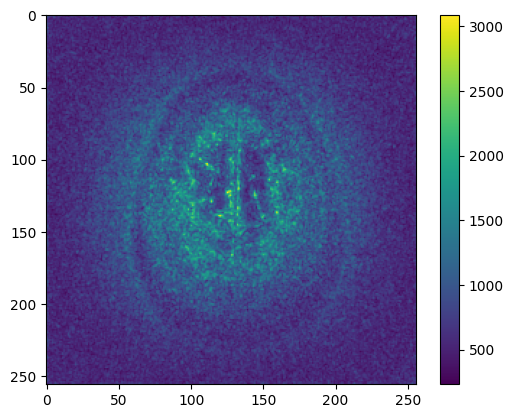

In [449]:
# Starting with some fake image, perform interpolation to resample the kspace points, then perform the adjoint nufft 

# kspace_complex = sigpy.ifft(np.array(parcel[1][:,::2] + parcel[1][:,1::2]*1j))
kspace_complex = sigpy.ifft(np.array(fake_image[:,::2] + fake_image[:,1::2]*1j))
interp_values = interpolate_values(np.array(parcel[3]['points']), kspace_complex).squeeze()
print(interp_values.shape)

# interp_values = NUFFT(fake_image, parcel[3]['points'])[0]
# print(interp_values.shape)

reconstructed_complex = NUFFT_adjoint_multicoil_custom(np.array(parcel[3]['points'][0]), interp_values, parcel[3]['kspace_raw'].shape[3:], parcel[3]['alpha'].item()*0.5)
reconstructed_2ch = np.zeros((reconstructed_complex.shape[0]*2,reconstructed_complex.shape[1],reconstructed_complex.shape[2]))
reconstructed_2ch[::2] = np.abs(reconstructed_complex)
reconstructed_2ch[1::2] = np.angle(reconstructed_complex)
reconstructed_2ch = torch.tensor(reconstructed_2ch.astype(np.float32))

# tensor_to_image((root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].unsqueeze(0)-10)*0.001)
plt.imshow(root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].permute(1,2,0))
# plt.imshow(root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].permute(1,2,0), vmin=500, vmax=3000)
plt.colorbar()

In [390]:
def NUFFT_adjoint_multicoil_custom(points,values,matshape,alpha):
    # values_c = fast_density_correction(points,values, alpha)
    values_c = values * np.power(np.power(points[:,0],2) + np.power(points[:,1],2), alpha)
    coils = values_c.shape[0]
    points = np.tile(points,(coils,1,1))
    image_complex = np.zeros((coils, matshape[0], matshape[1]), dtype=np.complex64)
    for i in range(coils):
        image_complex[i] = sigpy.nufft_adjoint(values_c[i], points[i], oshape=matshape, oversamp=1, width=4).astype(np.complex64)
    return image_complex

In [366]:
kspace_complex = sigpy.ifft(np.array(parcel[1][:,::2] + parcel[1][:,1::2]*1j))
# kspace_complex = sigpy.ifft(np.array(fake_image[:,::2] + fake_image[:,1::2]*1j))
interp_values = interpolate_values(np.array(parcel[3]['points']), kspace_complex).squeeze()
interp_values.shape

(24, 15207)

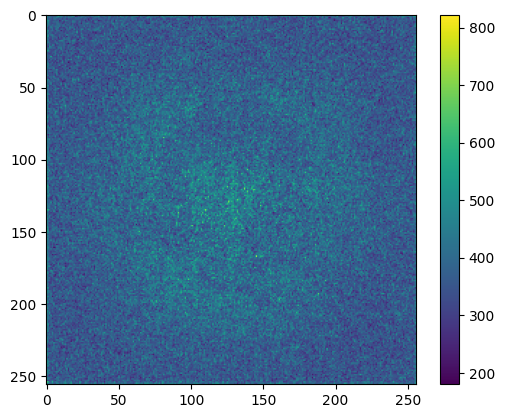

In [409]:
reconstructed_complex = NUFFT_adjoint_multicoil_custom(np.array(parcel[3]['points'][0]), interp_values, parcel[3]['kspace_raw'].shape[3:], 0.8)#parcel[3]['alpha'].item())
reconstructed_2ch = np.zeros((reconstructed_complex.shape[0]*2,reconstructed_complex.shape[1],reconstructed_complex.shape[2]))
reconstructed_2ch[::2] = np.abs(reconstructed_complex)
reconstructed_2ch[1::2] = np.angle(reconstructed_complex)
reconstructed_2ch = torch.tensor(reconstructed_2ch.astype(np.float32))

# tensor_to_image((root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].unsqueeze(0)-10)*0.001)
plt.imshow(root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].permute(1,2,0))
plt.colorbar()

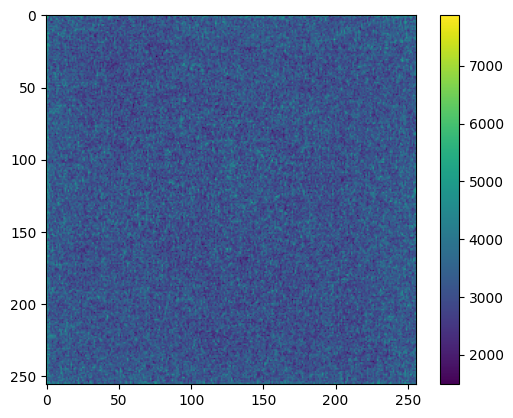

In [415]:
new_values = NUFFT(parcel[1], parcel[3]['points'])[0]
new_values.shape

reconstructed_complex = NUFFT_adjoint_multicoil_custom(np.array(parcel[3]['points'][0]), new_values, parcel[3]['kspace_raw'].shape[3:], 1)#parcel[3]['alpha'].item())
reconstructed_2ch = np.zeros((reconstructed_complex.shape[0]*2,reconstructed_complex.shape[1],reconstructed_complex.shape[2]))
reconstructed_2ch[::2] = np.abs(reconstructed_complex)
reconstructed_2ch[1::2] = np.angle(reconstructed_complex)
reconstructed_2ch = torch.tensor(reconstructed_2ch.astype(np.float32))

# tensor_to_image(root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].unsqueeze(0)/200-1)
plt.imshow(root_summed_squares(reconstructed_2ch.unsqueeze(0))[0].permute(1,2,0))
plt.colorbar()

# not using the nufft


In [219]:
# parcel = next(dataset_iterator)
x_next = fake_image
# x_next = parcel[1]
x_next.shape

torch.Size([1, 48, 256, 256])

In [220]:
parcel[3]['kspace_masked']

tensor([[[[ 3.3159e-06,  4.9993e-05,  2.6624e-05,  ..., -6.4788e-06,
            9.0207e-06,  7.4789e-06],
          [ 2.3498e-05,  3.9856e-05, -1.0920e-05,  ..., -4.6939e-05,
           -9.9660e-06,  2.4751e-05],
          [-5.6133e-06, -1.5135e-05, -3.5391e-05,  ..., -2.0287e-05,
           -1.8801e-05, -1.2014e-05],
          ...,
          [-8.4688e-06, -7.3639e-06, -1.7040e-05,  ...,  2.3518e-05,
            5.8879e-06, -1.1101e-06],
          [-9.9146e-06, -1.3142e-05, -7.9987e-06,  ...,  7.7723e-06,
           -7.0211e-06, -2.3875e-05],
          [-4.2305e-06,  4.7983e-05,  4.1453e-05,  ..., -2.8951e-06,
           -9.6294e-06, -2.8924e-05]],

         [[ 8.6841e-06,  4.3147e-06, -2.9812e-05,  ..., -2.0126e-05,
           -7.5511e-06,  2.5615e-05],
          [-4.9551e-06, -3.0142e-05, -4.5314e-05,  ..., -3.8833e-05,
           -4.3993e-05, -1.7342e-05],
          [-1.9135e-05, -2.0230e-05, -6.9526e-06,  ...,  1.5959e-06,
           -1.3139e-05, -2.1682e-05],
          ...,
     

In [221]:
# Calculate frequency space gradient
x_next_complex = x_next[:,::2] * (torch.cos(x_next[:,1::2]*torch.pi) + torch.sin(x_next[:,1::2]*torch.pi) * 1j)
k_next_complex = torch.fft.fftshift(torch.fft.fft2(x_next_complex))

# k_next = torch.cat((torch.zeros_like(k_next_complex),torch.zeros_like(k_next_complex)), dim=1)
# k_next[:,::2] = k_next_complex.real
# k_next[:,1::2] = k_next_complex.imag

# k_gradient_complex = k_complex-k_next_complex
# k_gradient_complex[k_complex==0+0j]=0+0j

# x_gradient_complex = torch.fft.fftshift(torch.fft.ifft2(k_gradient_complex))
# x_gradient = torch.cat((torch.zeros_like(x_gradient_complex),torch.zeros_like(x_gradient_complex)), dim=1).to(torch.float32)
# x_gradient[:,::2] = torch.abs(x_gradient_complex).to(torch.float32)
# x_gradient[:,1::2] = (torch.angle(x_gradient_complex)/torch.pi).to(torch.float32)

# Using Masking
# k_gradient_complex = k_complex-k_next_complex
k_gradient_complex = k_next_complex
# k_gradient_complex[torch.fft.fftshift(parcel[3]['kspace_masked'][:,::2])==0]=0

# x_gradient_complex = torch.fft.fftshift(torch.fft.ifft2(k_gradient_complex))
x_gradient_complex = torch.fft.ifft2(k_gradient_complex)

x_gradient = torch.cat((torch.zeros_like(x_gradient_complex),torch.zeros_like(x_gradient_complex)), dim=1).to(torch.float32)
x_gradient[:,::2] = torch.abs(x_gradient_complex).to(torch.float32)
x_gradient[:,1::2] = (torch.angle(x_gradient_complex)/torch.pi).to(torch.float32)

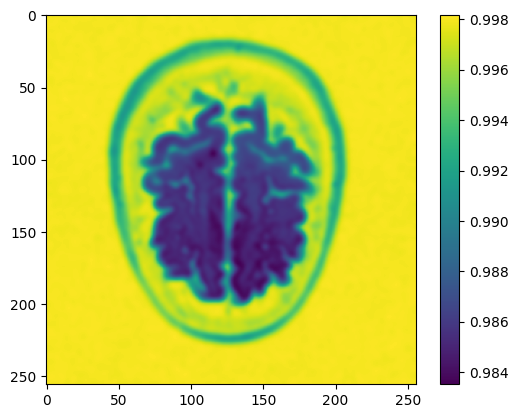

In [222]:
# tensor_to_image(root_summed_squares(x_gradient)[0].unsqueeze(0)*2-2)
plt.imshow(root_summed_squares(x_gradient)[0].permute(1,2,0))
plt.colorbar()

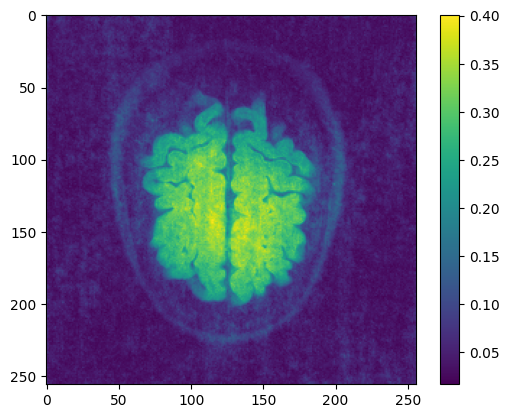

In [223]:
# tensor_to_image(root_summed_squares(parcel[1])[0].unsqueeze(0)*10-1)
plt.imshow(root_summed_squares(parcel[1])[0].permute(1,2,0))
plt.colorbar()

# Testing interpolation settings

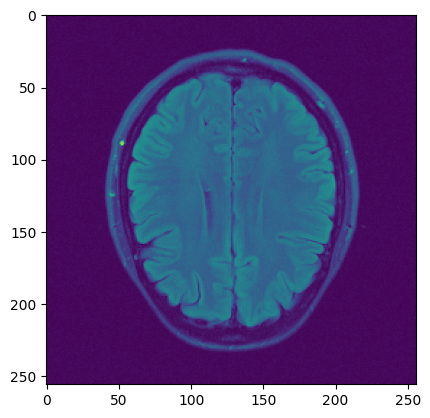

In [291]:
parcel = next(dataset_iterator)
plt.imshow(root_summed_squares(parcel[0])[0].permute(1,2,0))

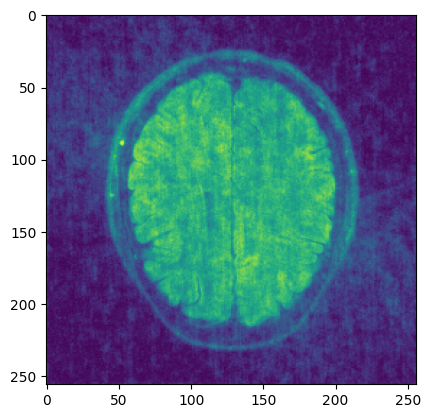

In [292]:
plt.imshow(root_summed_squares(parcel[1])[0].permute(1,2,0))

In [293]:
def interpolate_1(points,kimage):
    assert kimage.dtype == 'complex64'
    # return sigpy.interpolate(kimage, points, kernel='kaiser_bessel', width=3)
    mag_image = np.abs(sigpy.ifft(kimage))
    return sigpy.nufft(mag_image, points)

def interpolate_2(points,kimage, width=2):
    assert kimage.dtype == 'complex64'
    kimage = np.fft.fftshift(kimage)
    return sigpy.interpolate(kimage, points, kernel='kaiser_bessel', width=width)
    # mag_image = np.abs(sigpy.ifft(kimage))
    # return sigpy.nufft(mag_image, points)

In [294]:
# Generating a prior

kspace_2ch = np.array(parcel[3]['kspace_raw'][0])

# If for some reason you want to start with the masked, discretized kspace instead of the raw:
# kspace_masked = np.zeros(parcel[3]['kspace_raw'].shape, dtype=np.float32)
# kspace_masked[0,:,0,:,:] = parcel[3]['kspace_masked'][0,::2,:,:]
# kspace_masked[0,:,1,:,:] = parcel[3]['kspace_masked'][0,1::2,:,:]
# kspace_2ch = np.array(kspace_masked[0])


image_complex = np.zeros((kspace_2ch.shape[0],kspace_2ch.shape[2],kspace_2ch.shape[3]),dtype=np.complex64)
prior_complex = np.zeros((kspace_2ch.shape[0],kspace_2ch.shape[2],kspace_2ch.shape[3]),dtype=np.complex64)
points = make_trajectory(kspace_2ch[0,0,:,:].shape, interleaves = 4, undersampling = 0.1, alpha=1.5)
alpha = 2


channel_values = []
for coil in range(kspace_2ch.shape[0]):
    kspace_complex = kspace_2ch[coil,0,:,:]+kspace_2ch[coil,1,:,:]*1j
    values = interpolate_1(points,kspace_complex) #for complicated interpolation
    channel_values.append(np.array(values))
    # values = map_values(points,kspace_complex) #for simple value mapping
    prior_complex[coil,:,:] = NUFFT_adjoint(points, values, kspace_complex.shape,alpha)
    image_complex[coil,:,:] = sigpy.ifft(kspace_complex)
channel_values = [np.stack((val.real,val.imag)) for val in channel_values]
channel_values = np.concatenate(channel_values, axis=0)
del kspace_2ch

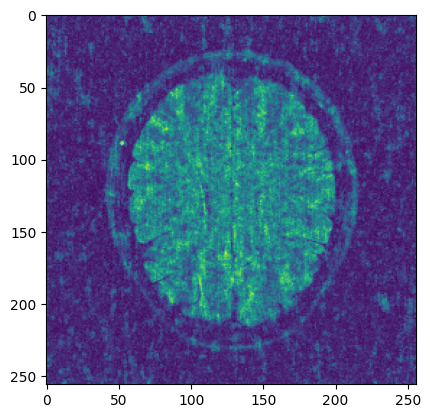

In [295]:
prior_magphase = np.zeros(parcel[0].shape)
prior_magphase[0,::2] = np.abs(prior_complex)
prior_magphase[0,1::2] = np.angle(prior_complex)
prior_magphase = torch.tensor(prior_magphase)
plt.imshow(root_summed_squares(prior_magphase)[0].permute(1,2,0))

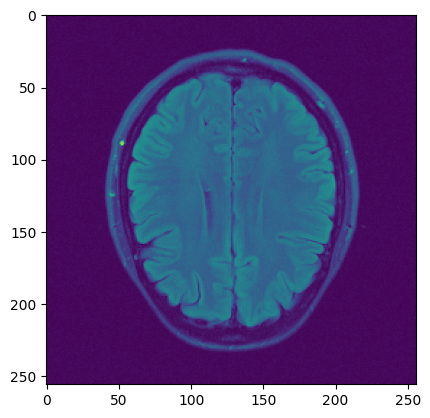

In [296]:
plt.imshow(root_summed_squares(parcel[0])[0].permute(1,2,0))

tensor(3.8272e-06)
tensor(3.9571e-06)


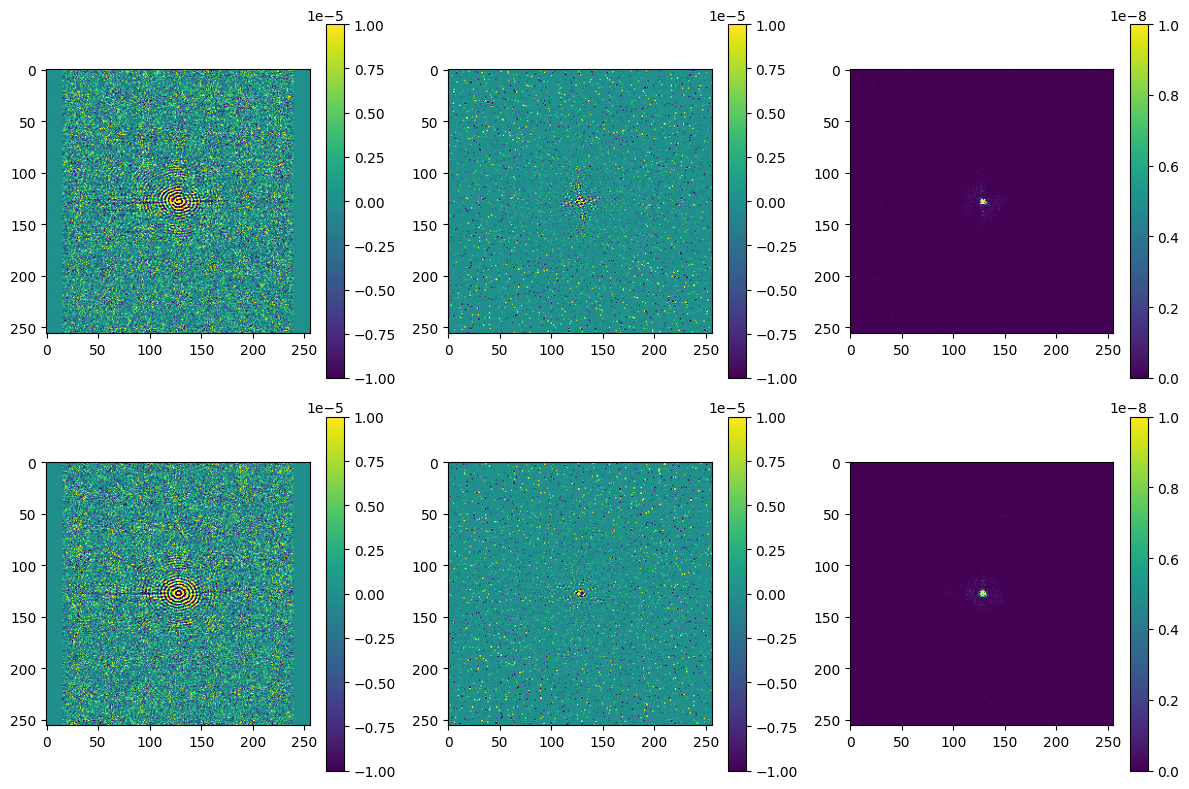

In [297]:
raw_kspace = np.zeros(image_complex.shape, dtype=np.complex64)
raw_kspace = parcel[3]['kspace_raw'][0][:,0] + parcel[3]['kspace_raw'][0][:,1]*1j
raw_kspace.shape

recon_kspace = torch.tensor(sigpy.fft(prior_complex))*0.1

fig, ax = plt.subplots(figsize=(12, 8), ncols=3, nrows=2, tight_layout=True)

vmin = -0.00001
vmax =  0.00001

pos1 = ax[0,0].imshow(raw_kspace[0].real, vmin=vmin, vmax=vmax)
fig.colorbar(pos1, ax=ax[0,0])
pos2 = ax[0,1].imshow(recon_kspace[0].real, vmin=vmin, vmax=vmax)
fig.colorbar(pos2, ax=ax[0,1])

pos4 = ax[1,0].imshow(raw_kspace[0].imag, vmin=vmin, vmax=vmax)
fig.colorbar(pos4, ax=ax[1,0])
pos5 = ax[1,1].imshow(recon_kspace[0].imag, vmin=vmin, vmax=vmax)
fig.colorbar(pos5, ax=ax[1,1])

real_diff = (raw_kspace[0].real-recon_kspace[0].real)**2
real_diff[parcel[3]['kspace_raw'][0,0,0]==0]=0
imag_diff = (raw_kspace[0].imag-recon_kspace[0].imag)**2
imag_diff[parcel[3]['kspace_raw'][0,0,0]==0]=0

print(torch.sum(real_diff))
print(torch.sum(imag_diff))

pos3 = ax[0,2].imshow(real_diff, vmin=0, vmax=vmax/1000)
fig.colorbar(pos3, ax=ax[0,2])
pos6 = ax[1,2].imshow(imag_diff, vmin=0, vmax=vmax/1000)
fig.colorbar(pos6, ax=ax[1,2])

In [310]:
# Generating a prior

kspace_2ch = np.array(parcel[3]['kspace_raw'][0])

# If for some reason you want to start with the masked, discretized kspace instead of the raw:
# kspace_masked = np.zeros(parcel[3]['kspace_raw'].shape, dtype=np.float32)
# kspace_masked[0,:,0,:,:] = parcel[3]['kspace_masked'][0,::2,:,:]
# kspace_masked[0,:,1,:,:] = parcel[3]['kspace_masked'][0,1::2,:,:]
# kspace_2ch = np.array(kspace_masked[0])


image_complex = np.zeros((kspace_2ch.shape[0],kspace_2ch.shape[2],kspace_2ch.shape[3]),dtype=np.complex64)
prior_complex = np.zeros((kspace_2ch.shape[0],kspace_2ch.shape[2],kspace_2ch.shape[3]),dtype=np.complex64)
points = make_trajectory(kspace_2ch[0,0,:,:].shape, interleaves = 4, undersampling = 0.1, alpha=1.5)
alpha = 2


channel_values = []
for coil in range(kspace_2ch.shape[0]):
    kspace_complex = kspace_2ch[coil,0,:,:]+kspace_2ch[coil,1,:,:]*1j
    values = interpolate_2(points,kspace_complex, width=2) #for complicated interpolation
    channel_values.append(np.array(values))
    # values = map_values(points,kspace_complex) #for simple value mapping
    prior_complex[coil,:,:] = NUFFT_adjoint(points, values, kspace_complex.shape,alpha)
    image_complex[coil,:,:] = sigpy.ifft(kspace_complex)
channel_values = [np.stack((val.real,val.imag)) for val in channel_values]
channel_values = np.concatenate(channel_values, axis=0)
del kspace_2ch

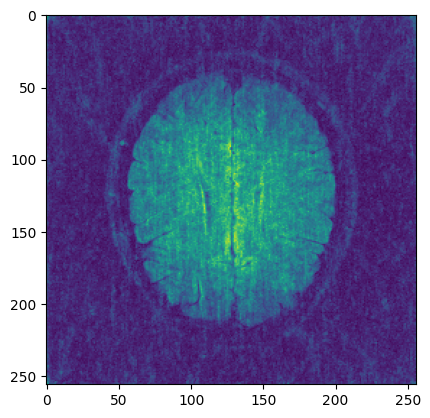

In [299]:
prior_magphase = np.zeros(parcel[0].shape)
prior_magphase[0,::2] = np.abs(prior_complex)
prior_magphase[0,1::2] = np.angle(prior_complex)
prior_magphase = torch.tensor(prior_magphase)
plt.imshow(root_summed_squares(prior_magphase)[0].permute(1,2,0))

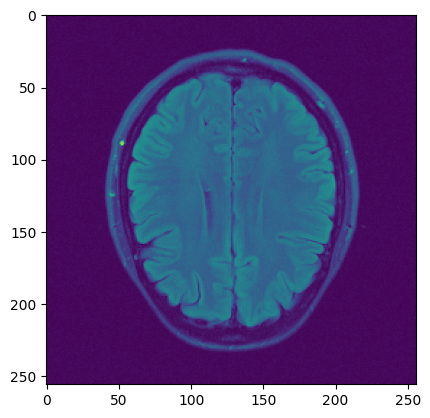

In [300]:
plt.imshow(root_summed_squares(parcel[0])[0].permute(1,2,0))

tensor(4.7876e-05)
tensor(6.1978e-05)


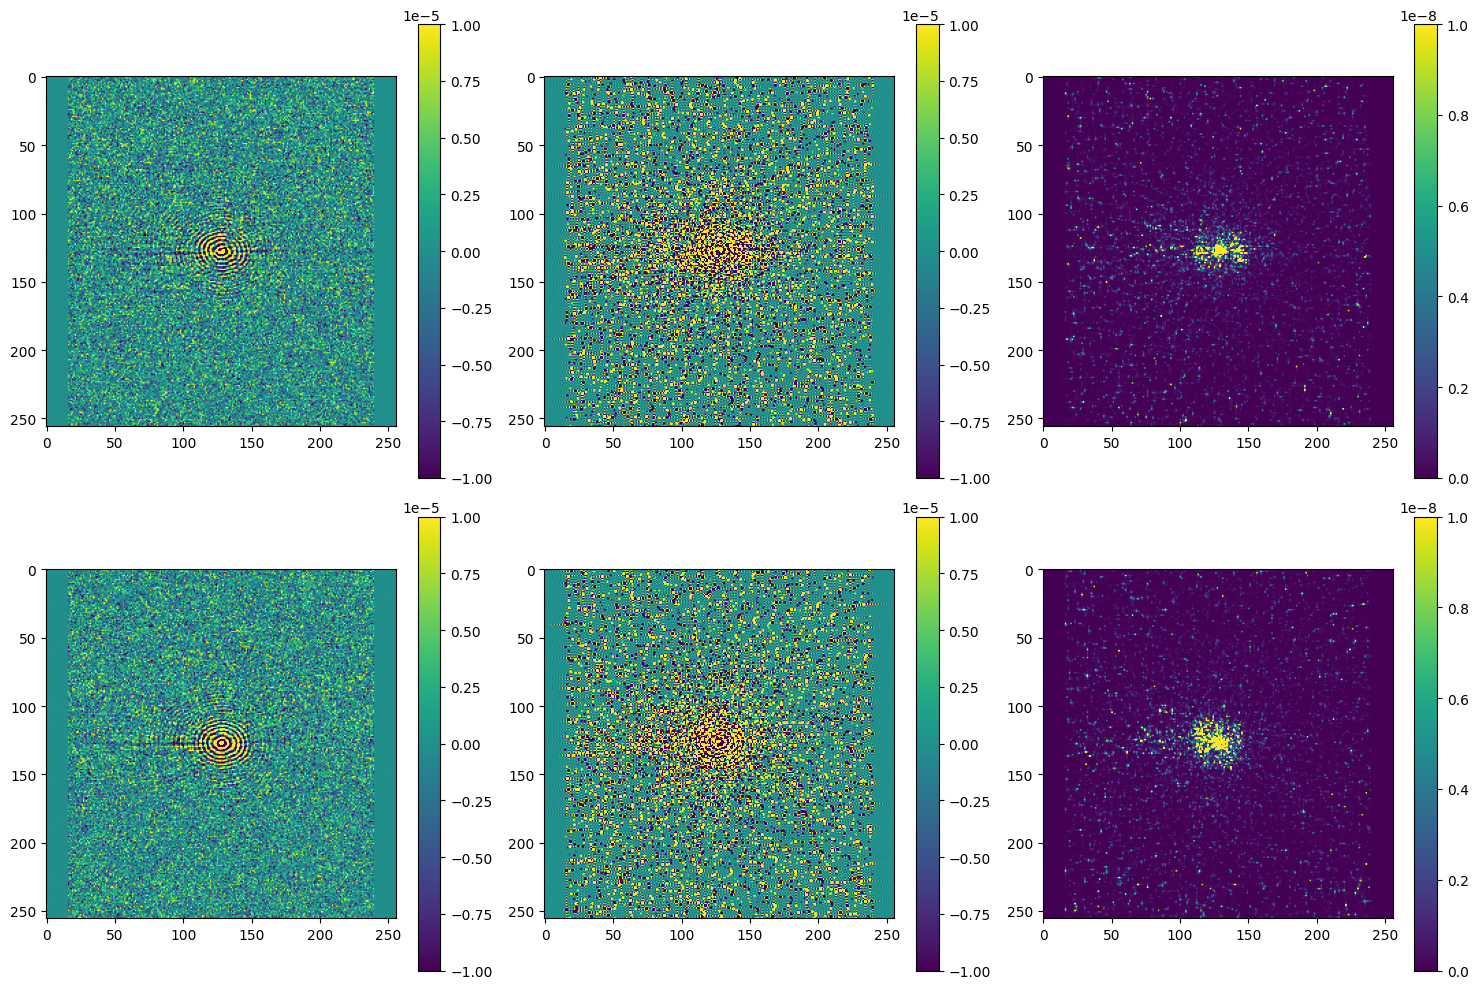

In [301]:
raw_kspace = np.zeros(image_complex.shape, dtype=np.complex64)
raw_kspace = parcel[3]['kspace_raw'][0][:,0] + parcel[3]['kspace_raw'][0][:,1]*1j
raw_kspace.shape

recon_kspace = torch.tensor(sigpy.fft(prior_complex))*0.1

fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2, tight_layout=True)

vmin = -0.00001
vmax =  0.00001

pos1 = ax[0,0].imshow(raw_kspace[0].real, vmin=vmin, vmax=vmax)
fig.colorbar(pos1, ax=ax[0,0])
pos2 = ax[0,1].imshow(recon_kspace[0].real, vmin=vmin, vmax=vmax)
fig.colorbar(pos2, ax=ax[0,1])

pos4 = ax[1,0].imshow(raw_kspace[0].imag, vmin=vmin, vmax=vmax)
fig.colorbar(pos4, ax=ax[1,0])
pos5 = ax[1,1].imshow(recon_kspace[0].imag, vmin=vmin, vmax=vmax)
fig.colorbar(pos5, ax=ax[1,1])

real_diff = (raw_kspace[0].real-recon_kspace[0].real)**2
real_diff[parcel[3]['kspace_raw'][0,0,0]==0]=0
imag_diff = (raw_kspace[0].imag-recon_kspace[0].imag)**2
imag_diff[parcel[3]['kspace_raw'][0,0,0]==0]=0

print(torch.sum(real_diff))
print(torch.sum(imag_diff))

pos3 = ax[0,2].imshow(real_diff, vmin=0, vmax=vmax/1000)
fig.colorbar(pos3, ax=ax[0,2])
pos6 = ax[1,2].imshow(imag_diff, vmin=0, vmax=vmax/1000)
fig.colorbar(pos6, ax=ax[1,2])